Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


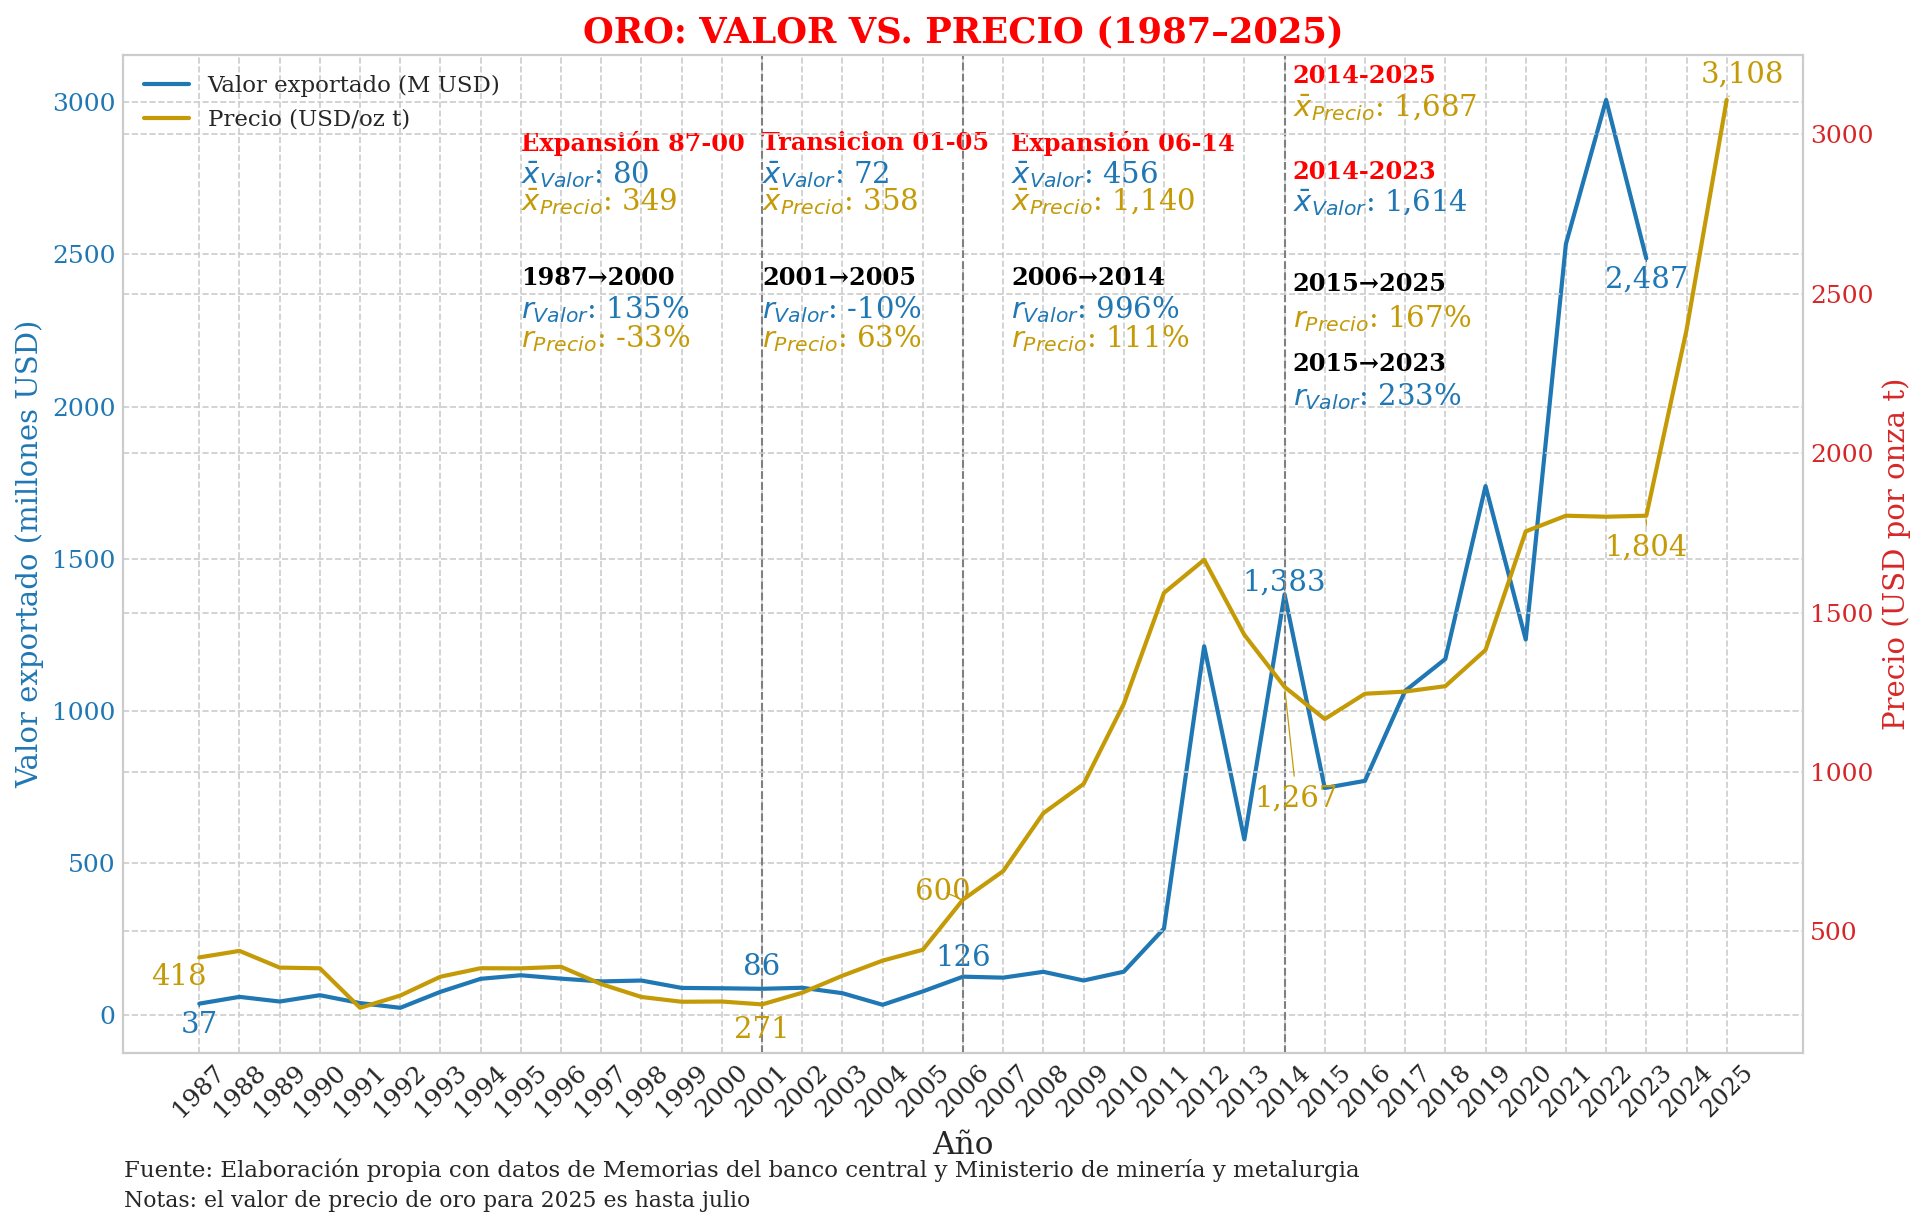

In [46]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *
# 0. Ciclos y carpetas
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)
set_style()
# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_oro = (pd.read_sql(
        "SELECT año, oro_volumen, oro_valor "
        "FROM exportaciones_minerales_totales where año > 1986", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, oro AS precio_usd_ot "
        "FROM precio_oficial_minerales where año > 1986", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio.loc[2025, 'precio_usd_ot'] = 3108.0
    df_precio = df_precio.sort_index()

df = df_oro.join(df_precio, how="outer")
df["oro_valor_musd"] = df["oro_valor"] / 1_000     # miles → millones
df.drop(columns="oro_valor", inplace=True)
df_base = df.loc[:2023]
df_price = df[["precio_usd_ot"]]
# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols_sectores     = ["oro_valor_musd", "precio_usd_ot"]
abbr     = {"oro_valor_musd": "Valor", "precio_usd_ot": "Precio"}
colors   = {"oro_valor_musd": "#1f77b4", "precio_usd_ot": "#c49b07"}   # azul + dorado
#1f77b4
CYCLES=adjust_cycles(df,CYCLES)
cycle_stats = {
    name: df.loc[period, cols_sectores].mean().to_dict()
    for name, period in CYCLES.items()
}
hitos_offset = {yr: .80 for yr in hitos_v}

anot_years=adjust_annot_years(df, annot_years)
anot_years.append(2023)
annotation_offsets = {
    "oro_valor_musd": {   # ajuste manual después de inspeccionar el gráfico
        1987:(0,-70), 2001:(0,70), 2006:(0,60), 2014:(0,40), 2023:(0,-70)
    },
    "precio_usd_ot": {
        1987:(-0.5,-60), 2001:(0.0,-80), 2006:(-0.5,25), 2014:(0.3,-350),2023:(0.0,-100), 2025:(0.4,80)
    },
}
# Defino dos listas de periodos:
growth_periods=adjust_periods(df,periodos_tasas)

period_growth_offsets = {
    "1987-2000": (1995,0.78), "2001-2005":(2001,0.78),
    "2006-2014": (2007.2,0.78)
}
cycle_text_offsets = {
    "Expansión 87-00": (1995,0.92),
    "Transicion 01-05":    (2001,0.92),
    "Expansión 06-14": (2007.2,0.92)
}

left_series  = [("oro_valor_musd", "Valor exportado (M USD)")]
right_series = [("precio_usd_ot",      "Precio (USD/oz t)")]

fig, ax_val, ax_price = init_dual_axis_plot(
    df=df,
    left_series=left_series,
    right_series=right_series,
    colors=colors,
    title=f"ORO: VALOR VS. PRECIO ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Valor exportado (millones USD)",
    right_ylabel="Precio (USD por onza t)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia",
    notas="Notas: el valor de precio de oro para 2025 es hasta julio",
)

# helpers
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"linewidth":1})
add_cycle_means_multi(
    ax_val, cycle_stats, cycle_text_offsets,
    abbr, colors, line_spacing=df["oro_valor_musd"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_cycle_means_multi(
    ax_val, {'2014-2025': {'precio_usd_ot': df.loc[2014:2025,'precio_usd_ot'].mean()}},
    {"2014-2025": (2014.2,0.99)},
    {"precio_usd_ot": "Precio"}, colors, line_spacing=df["precio_usd_ot"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_cycle_means_multi(
    ax_val, {'2014-2023': {'oro_valor_musd': df.loc[2014:2023,'oro_valor_musd'].mean()}},
    {"2014-2023": (2014.2,0.89)},
    {"oro_valor_musd": "Valor"}, colors, line_spacing=df["oro_valor_musd"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_year_value_annotations(
    ax_val,   df, anot_years, ["oro_valor_musd"],
    {"oro_valor_musd": annotation_offsets["oro_valor_musd"]},
    {"oro_valor_musd": colors["oro_valor_musd"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets["precio_usd_ot"]},
    {"precio_usd_ot": colors["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.0f}"
)


# Tasa sólo para el eje izquierdo (valor, hasta 2024)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods,
    cols_sectores,
    period_growth_offsets,
    colors,
    abbr,
)
growth_periods_for_price = [(2015,2025)]
add_period_growth_annotations_multi(
    ax_price, df, growth_periods_for_price,
    ['precio_usd_ot'],
    {
        "2015-2025": (2014.2, 0.79),
    },
    colors,
    {"precio_usd_ot": "Precio"},
)
growth_periods_for_val = [(2015,2023)]
add_period_growth_annotations_multi(
    ax_val, df, growth_periods_for_val,
    ['oro_valor_musd'],
    {
        "2015-2023": (2014.2, 0.69),
    },
    colors,
    {"oro_valor_musd": "Valor"},
)



# leyenda filtrada
h,l  = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl    = [(x,y) for x,y in zip(h+h2, l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "oro_valor_precio_dual_axis.png"), dpi=300)
plt.show()




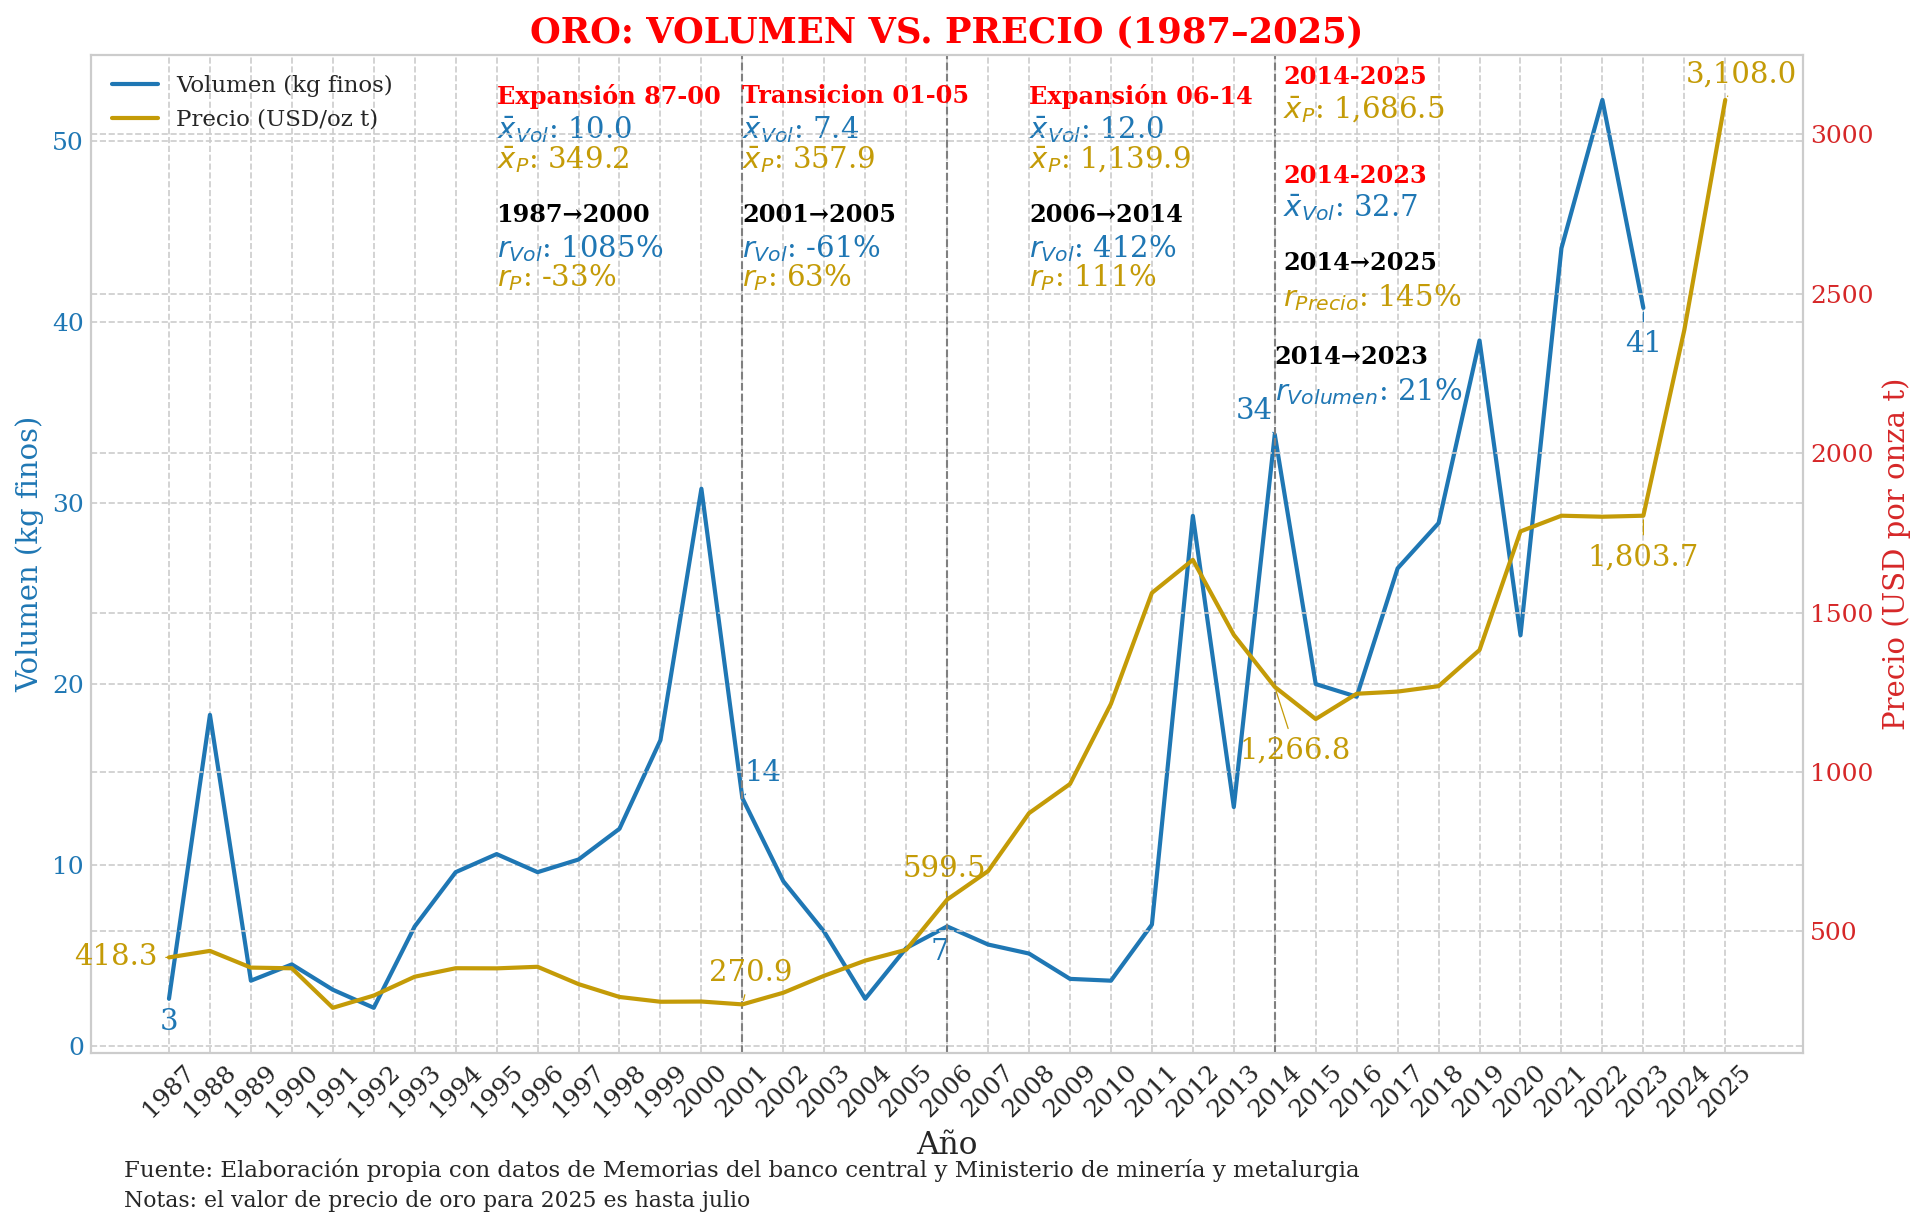

In [44]:
# ──────────────────────  GRÁFICA DUAL AXIS (volumen-precio) ─────────────────────
cols_vol   = ["oro_volumen", "precio_usd_ot"]
colors_vol = {
    "oro_volumen": "tab:blue",          # ya definido
    "precio_usd_ot": colors["precio_usd_ot"]   # dorado del primer gráfico
}
abbr_vol = {"oro_volumen": "Vol", "precio_usd_ot": "P"}
CYCLES=adjust_cycles(df,CYCLES)
cycle_stats_vol = {
    name: df.loc[period, cols_vol].mean().to_dict()
    for name, period in CYCLES.items()
}

annotation_offsets_vol = {
    "oro_volumen": {
        1987:(0,  -1.3), 2001:(0.5, 1.4), 2006:(-0.17,-1.4),
        2014:(-0.5,1.3), 2023:(0,-2.0)
    },
    "precio_usd_ot": {
        1987:(-1.3,0), 2001:(0.2, 100), 2006:(-0.08,95),
        2014:(0.5,-200), 2023:(0.0,-130), 2025:(0.4,80)
    }
}

period_growth_offsets_vol = {
    "1987-2000": (1995,0.85), "2001-2005":(2001,0.85),
    "2006-2014": (2008,0.85), "2015-2024":(2016,0.85)
}

cycle_text_offsets_vol = {
    "Expansión 87-00": (1995,0.97),
    "Transicion 01-05":    (2001,0.97),
    "Expansión 06-14": (2008,0.97),
}

# ────────────────────── GRÁFICA DUAL AXIS (volumen–precio) ─────────────────────
left_series_vol  = [("oro_volumen", "Volumen (kg finos)")]
right_series_vol = [("precio_usd_ot",  "Precio (USD/oz t)")]

fig_vol, ax_vol, ax_price_vol = init_dual_axis_plot(
    df=df,
    left_series=left_series_vol,
    right_series=right_series_vol,
    colors=colors_vol,
    title=f"ORO: VOLUMEN VS. PRECIO ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Volumen (kg finos)",
    right_ylabel="Precio (USD por onza t)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia",
    notas="Notas: el valor de precio de oro para 2025 es hasta julio",
)


# helpers
add_hitos(ax_vol, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})

# espaciado 3 % del rango visible
y_min, y_max  = ax_vol.get_ylim()
line_spacing  = (y_max - y_min) * 0.03

# ─── 1) medias estándar de los tres ciclos base (92-99 / 00-05 / 06-13) ───
add_cycle_means_multi(
    ax_vol, cycle_stats_vol,              # ← dict con 3 ciclos base
    cycle_text_offsets_vol,
    abbr_vol, colors_vol,
    line_spacing=line_spacing,
    value_fmt="{:,.1f}"
)

# ─── 2) media 2014-2025 SOLO para el precio ──────────────────────────────
mean_price_1425 = {'2014-2025': {'precio_usd_ot': df.loc[2014:2025, 'precio_usd_ot'].mean()}}

add_cycle_means_multi(
    ax_price_vol, mean_price_1425,
    {"2014-2025": (2014.2, 0.99)},      # posición del bloque
    {"precio_usd_ot": "P"},
    colors_vol,
    line_spacing=df['precio_usd_ot'].max() * 0.03,
    value_fmt="{:,.1f}"
)

# ─── 3) media 2014-2023 SOLO para el volumen ─────────────────────────────
mean_vol_1423 = {'2014-2023': {'oro_volumen': df.loc[2014:2023, 'oro_volumen'].mean()}}

add_cycle_means_multi(
    ax_vol, mean_vol_1423,
    {"2014-2023": (2014.2, 0.89)},      # posición del bloque
    {"oro_volumen": "Vol"},
    colors_vol,
    line_spacing=df['oro_volumen'].max() * 0.03,
    value_fmt="{:,.1f}"
)

add_year_value_annotations(
    ax_vol, df, anot_years, ["oro_volumen"],
    {"oro_volumen": annotation_offsets_vol["oro_volumen"]},
    {"oro_volumen": colors_vol["oro_volumen"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price_vol, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets_vol["precio_usd_ot"]},
    {"precio_usd_ot": colors_vol["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)

add_period_growth_annotations_multi(
    ax_vol, df, growth_periods, cols_vol,
    period_growth_offsets_vol, colors_vol, abbr_vol,
    line_spacing_ratio=0.03
)
growth_periods_for_price = [(2014,2025)]
add_period_growth_annotations_multi(
    ax_price_vol, df, growth_periods_for_price,
    ['precio_usd_ot'],
    {
        "2014-2025": (2014.2, 0.81),
    },
    colors_vol,
    {"precio_usd_ot": "Precio"},
)
growth_periods_for_vol = [(2014,2023)]
add_period_growth_annotations_multi(
    ax_price_vol, df, growth_periods_for_vol,
    ['oro_volumen'],
    {
        "2014-2023": (2014, 0.72),
    },
    colors_vol,
    {"oro_volumen": "Volumen"},
)

# leyenda combinada
h1,l1 = ax_vol.get_legend_handles_labels()
h2,l2 = ax_price_vol.get_legend_handles_labels()
ax_vol.legend(h1+h2, l1+l2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "oro_volumen_precio_dual_axis.png"), dpi=300)
plt.show()